In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import m2cgen as m2c
import pickle

import base64
import firebase_admin
from firebase_admin import credentials, firestore

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

In [2]:
df = pd.read_csv("Data_141124.csv")
df =df.drop('DateRecord', axis=1)
df =df.drop('TimeRecord', axis=1)
df.head()

,ax,ay,az,gx,gy,gz,mx,my,mz,target
0,-0.37,2.21,9.38,0.007636,0.014181,-0.004363,21.500,-27.250,2.50,0
1,-0.33,2.19,9.40,0.000000,-0.018544,0.003272,23.000,-26.875,2.50,0
2,-0.33,2.16,9.43,0.001091,-0.019635,0.004363,21.500,-27.250,1.75,0
3,-0.31,2.19,9.43,0.000000,-0.008727,0.000000,21.875,-25.750,1.75,0
4,-0.26,2.19,9.38,-0.001091,0.023998,-0.003272,21.875,-26.875,1.25,0


In [3]:
df.describe()

,ax,ay,az,gx,gy,gz,mx,my,mz,target
count,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000
mean,1.922148,0.087752,2.411477,0.012577,-0.000957,0.002154,18.673920,3.166527,3.507236,1.500000
std,2.365882,4.913305,7.451476,0.144687,0.094472,0.078474,11.116386,22.484901,13.409552,1.118503
min,-2.190000,-9.590000,-9.330000,-0.290161,-1.075559,-0.885755,-2.062500,-34.000000,-31.062500,0.000000
25%,-0.300000,-3.220000,-3.677500,-0.008727,-0.026180,-0.005454,11.109375,-25.750000,1.250000,0.750000
50%,0.960000,0.030000,7.645000,-0.001091,-0.001091,0.000000,21.875000,7.093750,2.875000,1.500000
75%,4.310000,2.310000,9.310000,0.005454,0.016362,0.006545,28.375000,19.718750,8.062500,2.250000
max,6.890000,10.100000,12.570000,3.023783,0.711222,1.253365,33.687500,33.875000,28.500000,3.000000


In [4]:
# Get descriptive statistics
desc_stats = df.describe()
# Extract the values of mean and std
means = desc_stats.loc['mean'][:-1]
stds = desc_stats.loc['std'][:-1]
# print the values in an easy-to-copy format
print("Mean and standard deviation values:")
for col in means.index: # Iterate only on means indexes
    print(f"({means[col]:.6f}))/{stds[col]:.6f};")

Mean and standard deviation values:
(1.922148))/2.365882;
(0.087752))/4.913305;
(2.411477))/7.451476;
(0.012577))/0.144687;
(-0.000957))/0.094472;
(0.002154))/0.078474;
(18.673920))/11.116386;
(3.166527))/22.484901;
(3.507236))/13.409552;


In [5]:
df['target'].unique()

array([0, 1, 2, 3])

# SCALE

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()
scaler.fit(df.iloc[:,:-1])

StandardScaler()

In [8]:
dfs = scaler.transform(df.iloc[:,:-1]).copy()
dfs

array([[-0.969241  ,  0.43212033,  0.93557954, ...,  0.25433323,
        -1.35332119, -0.07514483],
       [-0.95232689,  0.42804804,  0.9382647 , ...,  0.38932581,
        -1.33663633, -0.07514483],
       [-0.95232689,  0.42193961,  0.94229243, ...,  0.25433323,
        -1.35332119, -0.13109858],
       ...,
       [ 1.12388025,  0.05339754,  0.85770994, ..., -1.742432  ,
         1.28566726,  0.26524051],
       [ 0.9631962 ,  0.06154211,  0.80266419, ..., -1.742432  ,
         1.31625617,  0.20462395],
       [ 1.30993547,  0.02896381,  0.78923839, ..., -1.70305916,
         1.30513293,  0.23726364]])

In [9]:
from joblib import dump, load

In [10]:
dump(scaler, 'std_scaler.bin', compress=True)

['std_scaler.bin']

# TRAIN_SPLIT

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dfs[:,:], df['target'], random_state=0)

# Análisis Exploratorio de Datos (EDA, por sus siglas en inglés: Exploratory Data Analysis)  

Class distribution bar chart

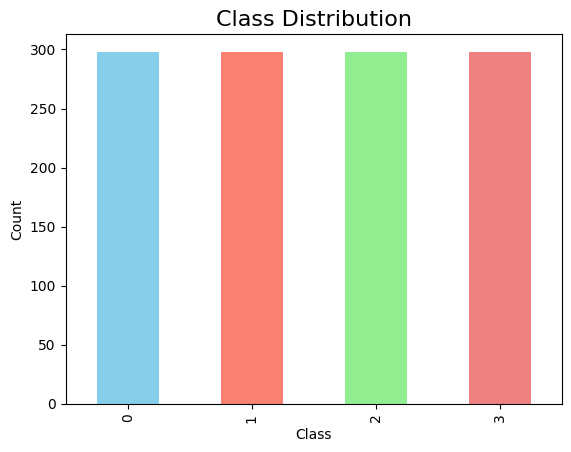

In [12]:
df['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'lightcoral'])
plt.title("Class Distribution", fontsize=16)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Correlation heat map (Heatmap)

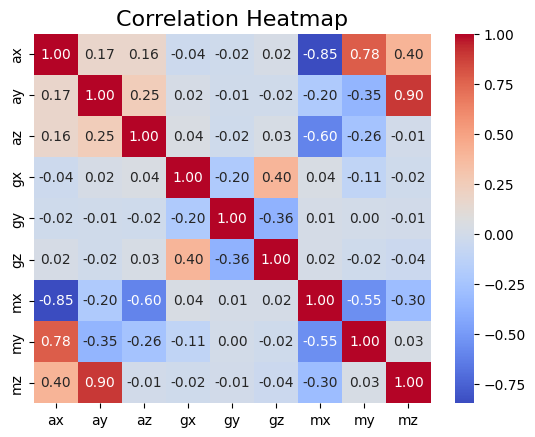

In [13]:
import seaborn as sns

df_cleaned = df.drop(['target'], axis=1)

corr_matrix = df_cleaned.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

X_train dimensions: (894, 9)
Number of relevant features: 8
Relevant characteristics: ['Mx', 'Mz', 'My', 'Ay', 'Az', 'Gx', 'Gz', 'Ax']


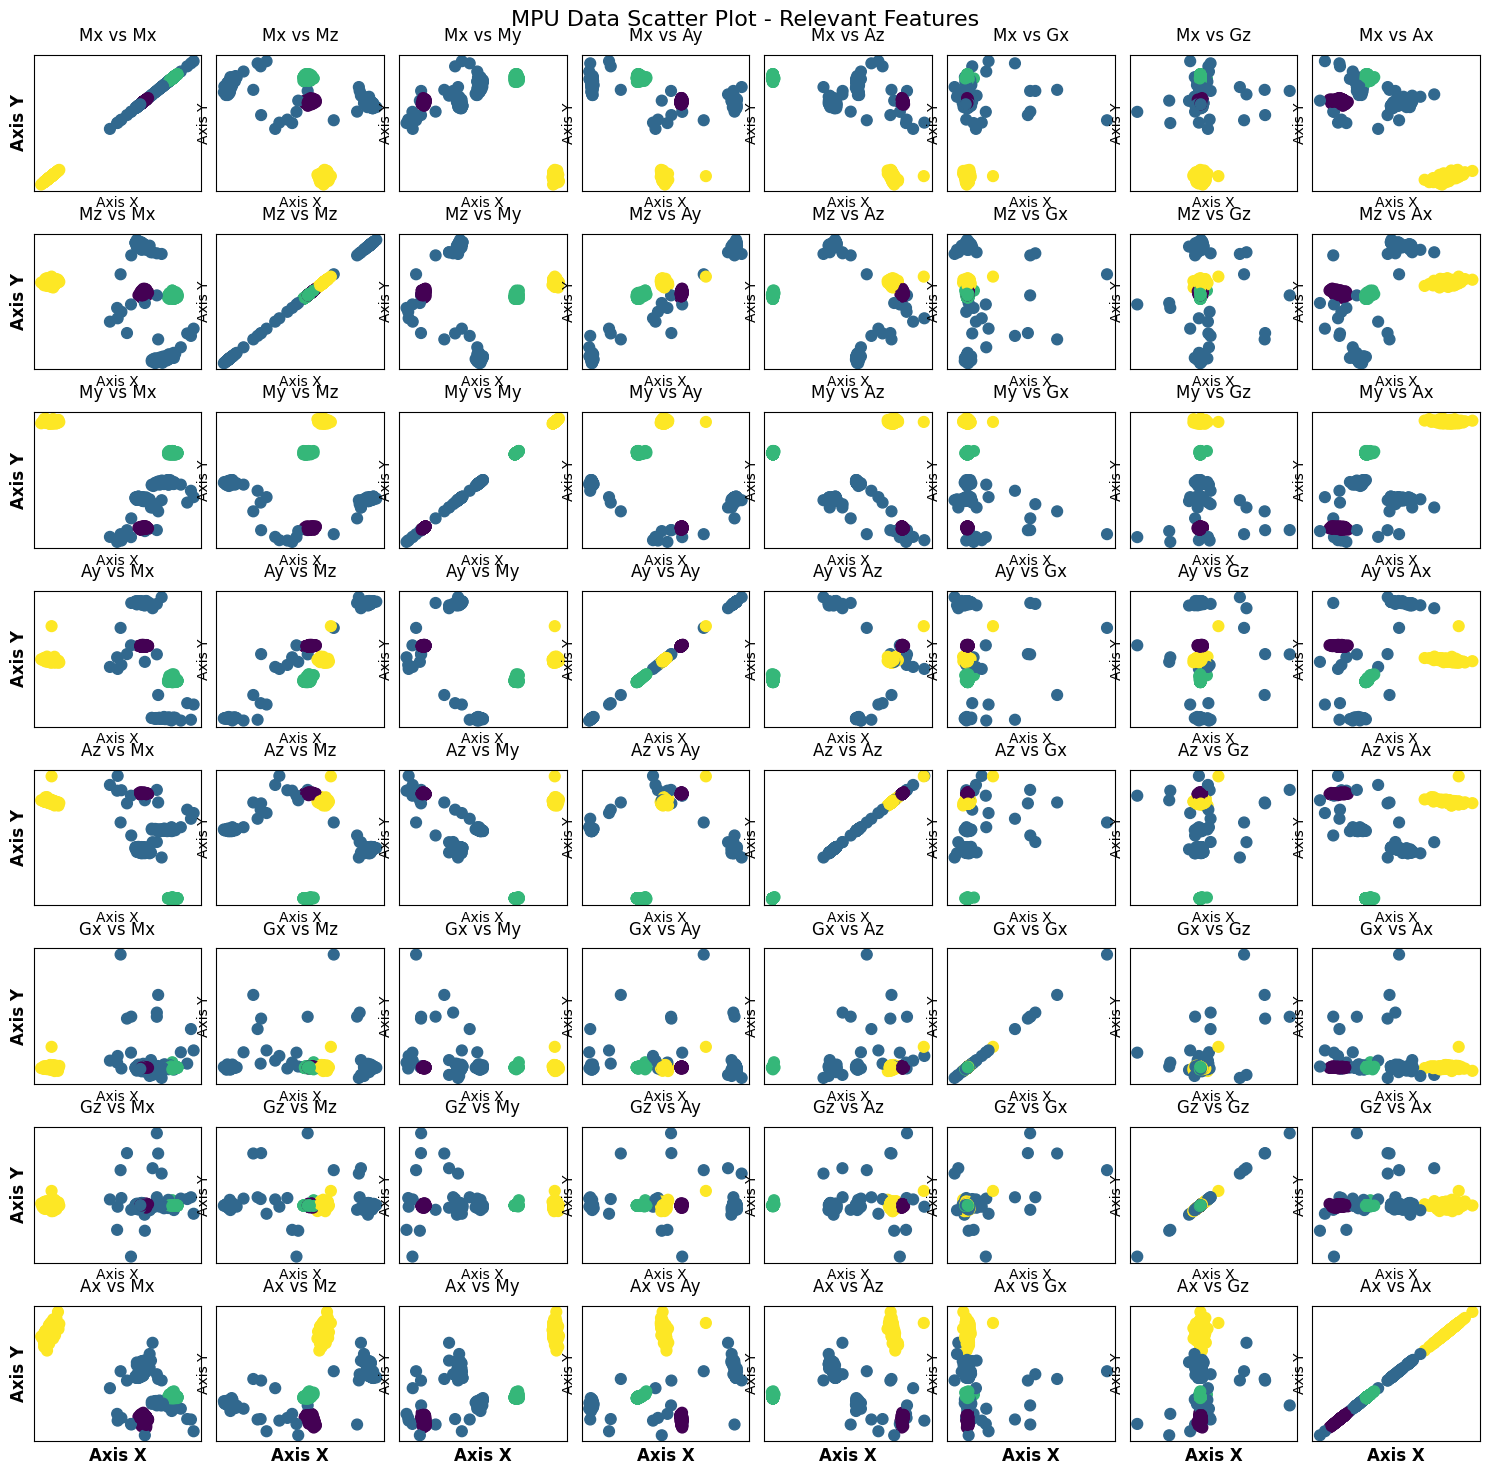

In [15]:
# suppose X_train is your data array (not including the target)
# y_train are the class labels

# Check the dimensions of X_train
print("X_train dimensions:", X_train.shape)

# If X_train has more than 9 columns, we select only the first 9 (characteristics)
X_train_filtered = X_train[:, :9] # This selects only the first 9 columns

# Converts X_train_filtered to a DataFrame to work with the column names
df = pd.DataFrame(X_train_filtered)

# List of features without including the target (if the target is in a separate column)
class_labels = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'Mx', 'My', 'Mz']

# Assign the column names
df.columns = class_labels

# Create the correlation matrix for the features only (not including the target)
correlation_matrix = df.corr().abs()

# Set correlation threshold to consider relevant pairs
threshold = 0.5 
relevant_pairs = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix < 1.0)].stack().index.tolist()

# Extract relevant features to plot
relevant_features = list(set([pair[0] for pair in relevant_pairs] + [pair[1] for pair in relevant_pairs]))

# Check how many relevant features have been selected
print(f"Number of relevant features: {len(relevant_features)}")
print(f"Relevant characteristics: {relevant_features}")

# Filter X_train with relevant characteristics only
X_train_filtered = df[relevant_features].values

# Create the graphics grid based on the relevant features
num_vars = len(relevant_features)
fig, ax = plt.subplots(num_vars, num_vars, figsize=(15, 15))

# General title for the figure
plt.suptitle("MPU Data Scatter Plot - Relevant Features", fontsize=16)

# Iterate over the rows and columns of the relevant variables
for i in range(num_vars):
    for j in range(num_vars):
        ax[i, j].scatter(X_train_filtered[:, j], X_train_filtered[:, i], c=y_train, s=60, cmap='viridis') # Color according to y_train.
        ax[i, j].set_xticks(())
        ax[i, j].set_yticks(())
        
        # Labels for axes
        if i == num_vars - 1:
            ax[i, j].set_xlabel(relevant_features[j], fontsize=12, fontweight='bold') # X-axis label.
        if j == 0:
            ax[i, j].set_ylabel(relevant_features[i], fontsize=12, fontweight='bold') # Y-axis label.

        # Titles of each subgraph with larger text and better spacing.  
        ax[i, j].set_title(f'{relevant_features[i]} vs {relevant_features[j]}', pad=10)

# Adjust the layout of the subgraphs to avoid overlaps.
plt.tight_layout()
plt.subplots_adjust(top=0.95) # Adjustment for general heading

# Adjust font size of X and Y axes in the whole chart
# plt.setp(fig.get_axes(), xlabel='Axis X', ylabel='Axis Y', fontsize=12) # Adjustment for overall axes
plt.setp(fig.get_axes(), xlabel='Axis X', ylabel='Axis Y') # Adjustment for overall axes

plt.show()

# ML DECISION TREE

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [17]:
dtree = DecisionTreeClassifier(random_state=0)

param_grid = {
    'max_depth': [2,3],                    #Depths 
    'min_samples_split':[15,30],           #Minimun number of samples to split a node
    'min_samples_leaf': [10,20],           #Minimun number of samples on a leaf
    'max_features':['auto','sqrt','log2'],
    'criterion': ['gini']                  #Division quality function
}

dtree_grid = GridSearchCV(estimator=dtree, param_grid=param_grid, cv=5, scoring='accuracy')
dtree_grid.fit(X_train, y_train)

print("Better hyperparameters:", dtree_grid.best_params_)
print("Accuracy with better hyperparameters (train):", dtree_grid.best_score_)

best_model = dtree_grid.best_estimator_
train_accuracy = best_model.score(X_train, y_train)
test_accuracy = best_model.score(X_test, y_test)

print("Accuracy in train set:", train_accuracy)
print("Accuracy in test set:", test_accuracy)

Better hyperparameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 15}
Accuracy with better hyperparameters (train): 0.9586466637373674
Accuracy in train set: 0.9932885906040269
Accuracy in test set: 0.9899328859060402


C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pac

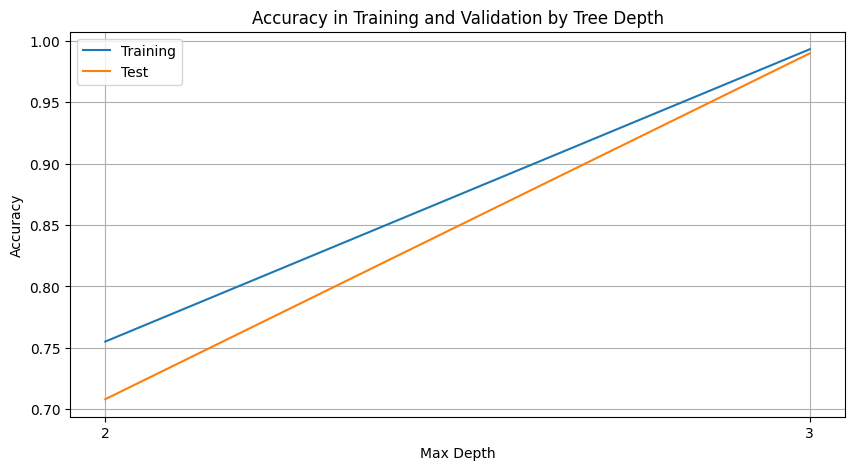

In [18]:
n_l_tr = []
n_l_ts = []

best_params = dtree_grid.best_params_
best_min_samples_leaf = best_params['min_samples_leaf']
best_min_samples_split = best_params['min_samples_split']

# Iterate over each tree depth to calculate accuracies.
for depth in param_grid['max_depth']:
    model = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split, random_state=0)
    model.fit(X_train, y_train)
    
    n_l_tr.append(model.score(X_train, y_train))
    n_l_ts.append(model.score(X_test, y_test))

# Graphing accuracy
plt.figure(figsize=(10, 5))
plt.plot(param_grid['max_depth'], n_l_tr, label='Training')
plt.plot(param_grid['max_depth'], n_l_ts, label='Test')

plt.title("Accuracy in Training and Validation by Tree Depth")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.xticks(param_grid['max_depth'])
plt.legend()
plt.grid()

plt.show()

Confusion Matrix:
[[64  0  0  0]
 [ 3 76  0  0]
 [ 0  0 71  0]
 [ 0  0  0 84]]
Model Accuracy:
0.9899328859060402

Classification Report (Precision, Recall, F1-Score):
              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98        64
     Class 1       1.00      0.96      0.98        79
     Class 2       1.00      1.00      1.00        71
     Class 3       1.00      1.00      1.00        84

    accuracy                           0.99       298
   macro avg       0.99      0.99      0.99       298
weighted avg       0.99      0.99      0.99       298



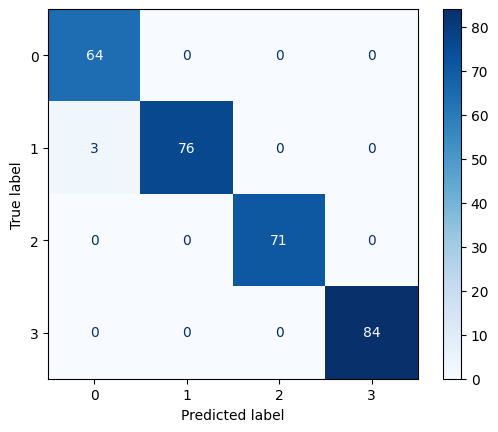

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

# Calculate and display accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:")
print(accuracy)

# Generate and display the classification report
report = classification_report(y_test, y_pred, target_names=[f"Class {cls}" for cls in best_model.classes_])
print("\nClassification Report (Precision, Recall, F1-Score):")
print(report)

In [20]:
code = m2c.export_to_c(model)

# Save the Java code to a text file, and print the training time and export time
with open('trained_model_dtree.txt', 'w') as f:
    f.write(code)
    print("Trained model saved to trained_model.py")  

Trained model saved to trained_model.py


In [21]:
# Save the trained model
pickle.dump(dtree, open("./dtree_mpu9050_1.sav", "wb"))

In [22]:
# Initializes the Firebase application
cred = credentials.Certificate('credentials.json')

# Check if the app is already initialized
if not firebase_admin._apps:
    cred = credentials.Certificate('credentials.json')
    firebase_admin.initialize_app(cred)
    
    
# Read the .sav file and convert it to base64
file_path = 'dtree_mpu9050_1.sav'
with open(file_path, 'rb') as file:
    encoded_string = base64.b64encode(file.read()).decode('utf-8')

# Connect to Firestore
db = firestore.client()

# Upload the base64 encoded file to the Firestore
doc_ref = db.collection('models').document('dtree_mpu9050_1')  # You can change the name of the collection and document.
doc_ref.set({
    'model': encoded_string
})

print("File successfully uploaded to Firestore")

File successfully uploaded to Firestore
